# Pretty color images of the line maps


In [33]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import make_lupton_rgb
from astropy.visualization.lupton_rgb import LinearMapping
from astropy.io import fits
from astropy.wcs import WCS
import seaborn as sns
from mpdaf.obj import Image
import regions
import sys
import pandas as pd
import cmasher as cmr
import pyneb as pn

sns.set_context("talk")
sns.set_color_codes()

In [38]:
datadir = Path("../data")
HDU = "DATA"
def load_and_scale_image(fn, v1, v2, ihdu=HDU):
    data = fits.open(datadir / f"ngc346-{fn}.fits")[ihdu].data
    return (data - v1) / (v2 - v1)


def make_rgb_wcs(chandata):
    chan_images = []
    for chanid, v1, v2 in chandata:
        chan_images.append(load_and_scale_image(chanid, v1, v2))
    w = WCS(fits.open(datadir / f"ngc346-{chanid}.fits")[HDU].header)
    return chan_images, w

STRETCH = 0.9
Q = 2.5

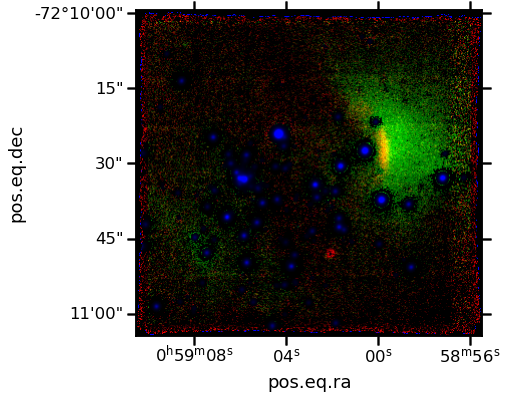

In [39]:
chandata = [
    ["heii-4686-correct", 0.0, 400.0],
    ["ariv-4711-plus-4740-correct", 0.0, 700.0],
    ["cont-4686-mean", 0.0, 3e4],
]
[r, g, b], w = make_rgb_wcs(chandata)
#image = make_lupton_rgb(r, g, b, stretch=STRETCH, Q=Q)
image = LinearMapping(0.0, 1.0).make_rgb_image(r, g, b)
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=w.celestial))
ax.imshow(image)


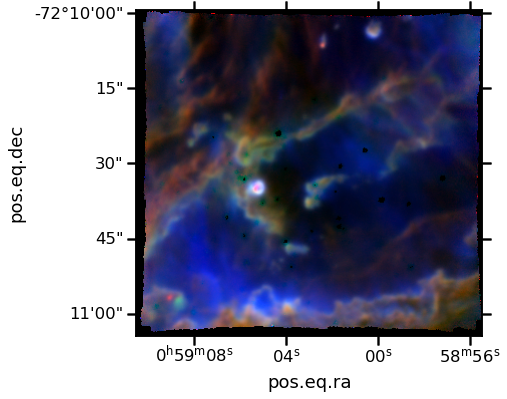

In [46]:
chandata = [
    ["oi-6300-bin01-sum", 0.0, 1500.0],
    ["sii-6731-bin01-sum", 0.0, 7000.0],
    ["siii-9069-bin01-sum", 0.0, 6e3],
]
[r, g, b], w = make_rgb_wcs(chandata)
image = make_lupton_rgb(r, g, b, stretch=STRETCH, Q=Q)
#image = LinearMapping(0.0, 1.0).make_rgb_image(r, g, b)
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=w.celestial))
ax.imshow(image)

In [47]:
import wcsfile

ModuleNotFoundError: No module named 'wcsfile'